In [1]:
import os
import cv2

def getlabel(file_name):
    return file_name.split('-')[1][:-4]
    
def load_image(img_path, img_size):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    height, width, _ = image.shape
    diff = height-width
    if diff > 0:
        image = cv2.copyMakeBorder(image, 0, 0, diff//2, diff//2, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    elif diff < 0:
        image = cv2.copyMakeBorder(image, -diff//2, -diff//2, 0, 0, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)
    return image

In [2]:
classes = (
    'none', 'slide', 'rollup',
    'double_d', 'double_u',
    'opposite_ul_dl', 'opposite_ul_dr', 'opposite_ur_dl', 'opposite_ur_dr',
    'single_dl', 'single_dr', 'single_ul', 'single_ur',
)

classes_to_ignore = ()

class_map = {
    'Door Fold Beside': classes.index('slide'),
    'Door None Beside': classes.index('none'),
    'Door ParallelSlide Beside': classes.index('slide'),
    'Door RollUp Beside': classes.index('rollup'), 
    'Door Slide Beside': classes.index('slide'),
    'Door Zfold Beside': classes.index('slide'),
    'Double_d': classes.index('double_d'),
    'Double_u': classes.index('double_u'),
    'Opposite_ul_dl': classes.index('opposite_ul_dl'),
    'Opposite_ul_dr': classes.index('opposite_ul_dr'),
    'Opposite_ur_dl': classes.index('opposite_ur_dl'),
    'Opposite_ur_dr': classes.index('opposite_ur_dr'),
    'Single_dl': classes.index('single_dl'),
    'Single_dr': classes.index('single_dr'),
    'Single_ul': classes.index('single_ul'),
    'Single_ur': classes.index('single_ur'),
}
class_map

{'Door Fold Beside': 1,
 'Door None Beside': 0,
 'Door ParallelSlide Beside': 1,
 'Door RollUp Beside': 2,
 'Door Slide Beside': 1,
 'Door Zfold Beside': 1,
 'Double_d': 3,
 'Double_u': 4,
 'Opposite_ul_dl': 5,
 'Opposite_ul_dr': 6,
 'Opposite_ur_dl': 7,
 'Opposite_ur_dr': 8,
 'Single_dl': 9,
 'Single_dr': 10,
 'Single_ul': 11,
 'Single_ur': 12}

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import pytorch_lightning as pl
import torchmetrics as tm
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

class Doors(data.Dataset):
    def __init__(self, split, img_size=40):
        self.folder = f'../doors/{split}/'
        self.files = os.listdir(self.folder)
        self.files = tuple(filter(lambda f: all(c not in f for c in classes_to_ignore), os.listdir(self.folder)))
        self.classes = {c: idx for idx, c in enumerate(classes)}
        self.img_size = img_size
        self.split = split

        self.transform = transforms.Compose([
            transforms.RandomRotation(7.5),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        label = getlabel(name)
        img = load_image(self.folder + name, self.img_size)
        img = np.moveaxis(img, 2, 0)
        img = (img / 255) * 2 - 1
        if (self.split == 'train'):
            return self.transform(torch.tensor(img).float()), class_map[label]
        else:
            return torch.tensor(img).float(), class_map[label]

In [11]:
import torchvision.models as models

class Net(pl.LightningModule):

    def __init__(self, classes):
        super().__init__()
        self.n_classes = len(classes)

        self.net = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        in_features = self.net.classifier[1].in_features
        self.net.classifier[1] = nn.Linear(in_features, len(classes))

        self.accuracy = tm.Accuracy()


    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
 
    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [12]:
name = 'effnetv2-s-all-classes-replaced'
model = Net(classes)

trainloader = data.DataLoader(Doors('train'), batch_size=64, shuffle=True, num_workers=6)
valloader = data.DataLoader(Doors('val'), batch_size=64, num_workers=6)

logger = pl.loggers.TensorBoardLogger('../lightning_logs', name=name, version=1)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=-1,
    logger=logger,
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        # pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=3),
        pl.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True, save_top_k=3, filename='{epoch}-{val_loss:.3f}-{val_acc:.3f}')
    ],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, trainloader, valloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type         | Params
------------------------------------------
0 | net      | EfficientNet | 20.2 M
1 | accuracy | Accuracy     | 0     
------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.777    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/mnt/c/Users/joaodavid/Desktop/CubiCasa5k/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
testloader = data.DataLoader(Doors('test'), batch_size=32, num_workers=4)
trainer.test(model, testloader, ckpt_path=f'../lightning_logs/{name}/version_1/checkpoints/epoch=1-val_loss=0.387-val_acc=0.893.ckpt')

Restoring states from the checkpoint path at ../lightning_logs/effnetv2-s-all-classes-replaced/version_1/checkpoints/epoch=1-val_loss=0.387-val_acc=0.893.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../lightning_logs/effnetv2-s-all-classes-replaced/version_1/checkpoints/epoch=1-val_loss=0.387-val_acc=0.893.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9021942615509033
        val_loss            0.29978010058403015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.29978010058403015, 'val_acc': 0.9021942615509033}]

In [18]:
testloader = data.DataLoader(Doors('test'), batch_size=4, num_workers=1)
all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for x, y in testloader:
        preds = model(x).argmax(1).numpy()
        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

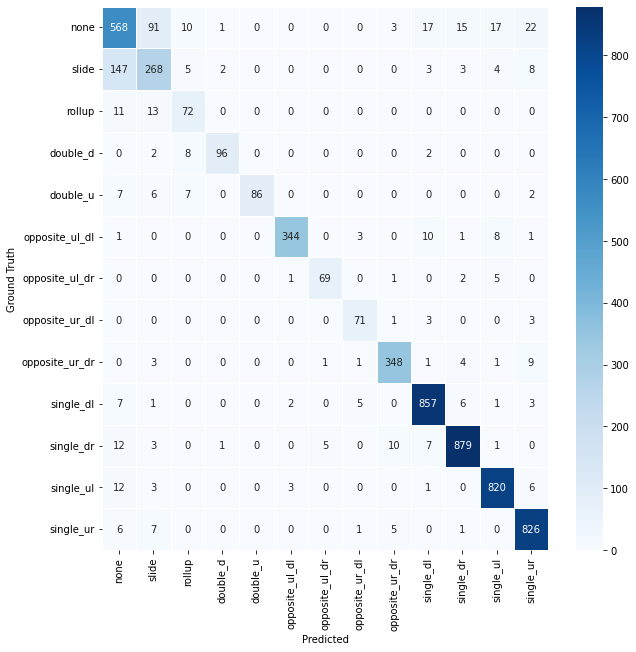

In [19]:
import seaborn as sn

cm = tm.ConfusionMatrix(len(classes))
matrix = cm(all_preds, all_gt).numpy()

plt.figure(figsize=(10, 10))
ax = plt.axes()
ax = sn.heatmap(matrix, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig(f'../report/{name}.svg')
plt.show()

In [20]:
tp = np.diag(matrix)
acc = tp/np.sum(matrix, axis=1)
precision = tp/np.sum(matrix, axis=0)

print('class,'+ ','.join(classes))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision]))

class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur
accuracy,76.34,60.91,75.00,88.89,79.63,93.48,88.46,91.03,94.57,97.17,95.75,97.04,97.64
precision,73.67,67.51,70.59,96.00,100.00,98.29,92.00,87.65,94.57,95.12,96.49,95.68,93.86


In [34]:
# torch.save(model.state_dict(), 'CONVNEXT-TINY.pth')

class Net(nn.Module):

    def __init__(self, classes):
        super().__init__()
        self.n_classes = len(classes)

        self.backbone = models.convnext_tiny(pretrained=False)

        self.fc1 = nn.Linear(1000, self.n_classes)


    def forward(self, x):
        x = self.backbone(x).flatten(1)
        x = self.fc1(x)
        return x


model2 = Net(classes)
model2.load_state_dict(torch.load('CONVNEXT-TINY.pth'))

<All keys matched successfully>

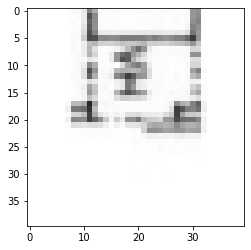

Expected: 3: Door Slide Beside
Predicted: 14: Single_ur


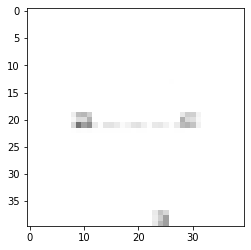

Expected: 3: Door Slide Beside
Predicted: 0: Door None Beside


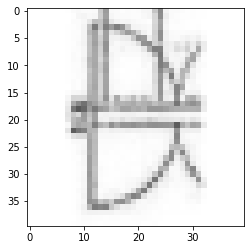

Expected: 7: Opposite_ul_dl
Predicted: 11: Single_dl


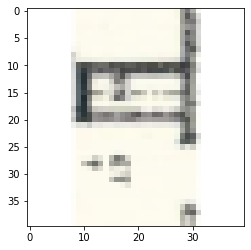

Expected: 1: Door ParallelSlide Beside
Predicted: 0: Door None Beside


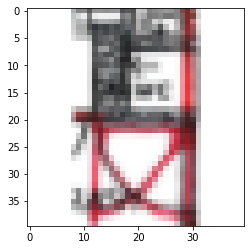

Expected: 11: Single_dl
Predicted: 12: Single_dr


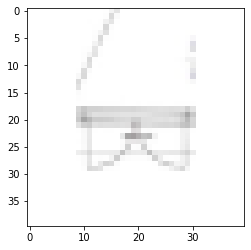

Expected: 5: Double_d
Predicted: 12: Single_dr


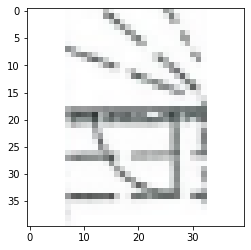

Expected: 14: Single_ur
Predicted: 12: Single_dr


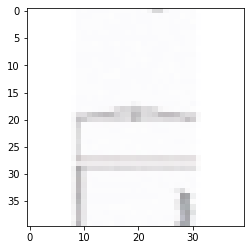

Expected: 6: Double_u
Predicted: 0: Door None Beside


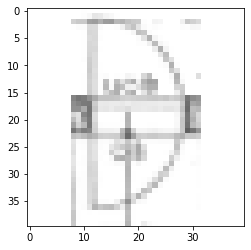

Expected: 7: Opposite_ul_dl
Predicted: 13: Single_ul


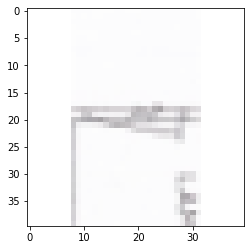

Expected: 11: Single_dl
Predicted: 0: Door None Beside


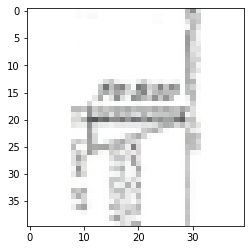

Expected: 12: Single_dr
Predicted: 14: Single_ur


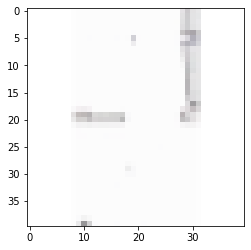

Expected: 3: Door Slide Beside
Predicted: 0: Door None Beside


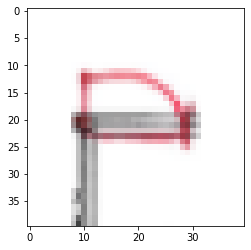

Expected: 13: Single_ul
Predicted: 14: Single_ur


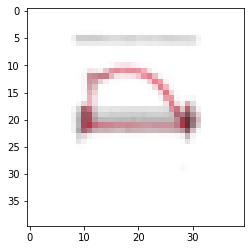

Expected: 13: Single_ul
Predicted: 14: Single_ur


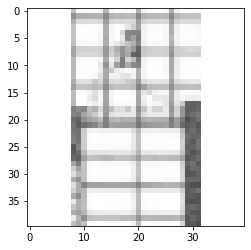

Expected: 0: Door None Beside
Predicted: 14: Single_ur


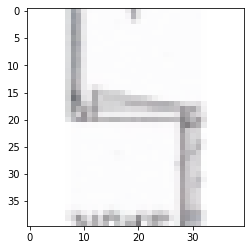

Expected: 14: Single_ur
Predicted: 0: Door None Beside


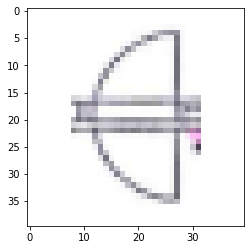

Expected: 10: Opposite_ur_dr
Predicted: 14: Single_ur


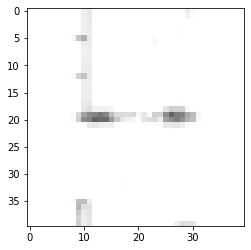

Expected: 4: Door Zfold Beside
Predicted: 0: Door None Beside


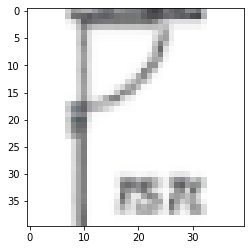

Expected: 12: Single_dr
Predicted: 13: Single_ul


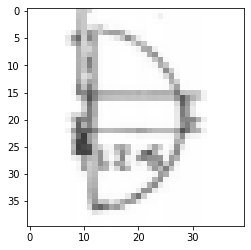

Expected: 7: Opposite_ul_dl
Predicted: 13: Single_ul


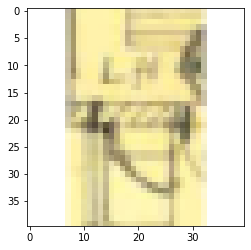

Expected: 12: Single_dr
Predicted: 11: Single_dl


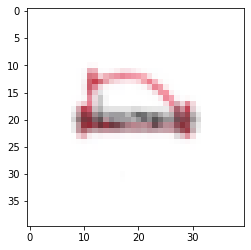

Expected: 13: Single_ul
Predicted: 14: Single_ur


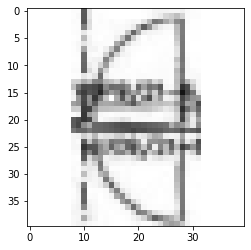

Expected: 10: Opposite_ur_dr
Predicted: 12: Single_dr


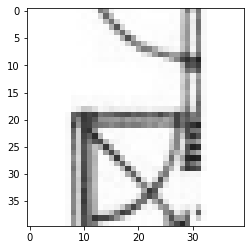

Expected: 11: Single_dl
Predicted: 13: Single_ul


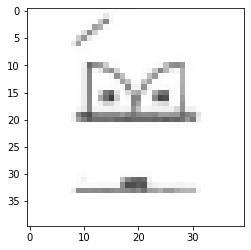

Expected: 6: Double_u
Predicted: 14: Single_ur


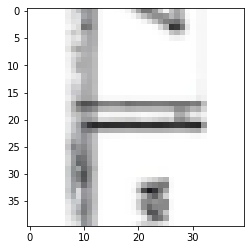

Expected: 0: Door None Beside
Predicted: 11: Single_dl


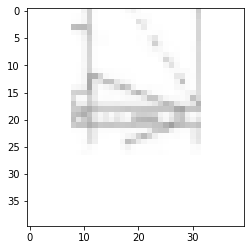

Expected: 10: Opposite_ur_dr
Predicted: 12: Single_dr


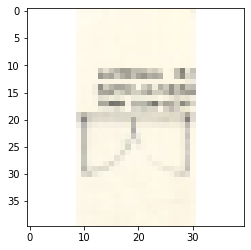

Expected: 5: Double_d
Predicted: 0: Door None Beside


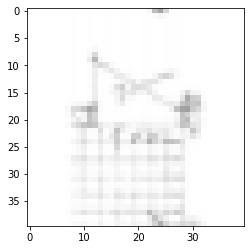

Expected: 14: Single_ur
Predicted: 11: Single_dl


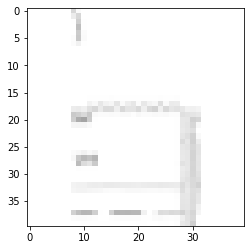

Expected: 4: Door Zfold Beside
Predicted: 12: Single_dr


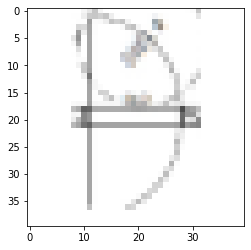

Expected: 7: Opposite_ul_dl
Predicted: 11: Single_dl


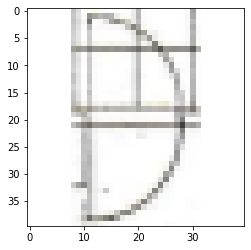

Expected: 7: Opposite_ul_dl
Predicted: 11: Single_dl


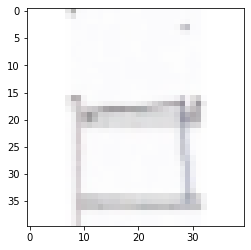

Expected: 13: Single_ul
Predicted: 0: Door None Beside


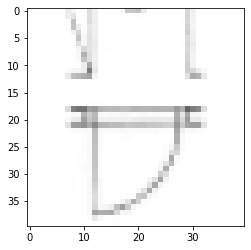

Expected: 12: Single_dr
Predicted: 11: Single_dl


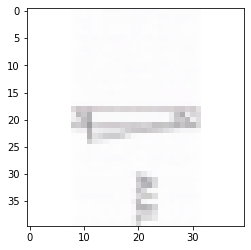

Expected: 12: Single_dr
Predicted: 11: Single_dl


In [49]:
with torch.no_grad():
    for idx, (img, label) in enumerate(iter(testloader)):
        if preds[idx] != targets[idx]:
            img_rgb = ((img.numpy() + 1)/2 * 255).astype(np.int)[0]
            img_rgb = np.moveaxis(img_rgb, 0, 2)
            plt.imshow(img_rgb)
            plt.show()
            print(f'Expected: {label.item()}: {classes[label]}')
            predict = model(img).argmax().item()
            print(f'Predicted: {predict}: {classes[predict]}')
            
        

In [27]:
example = iter(testloader)

In [40]:
testloader = data.DataLoader(Doors('test'), batch_size=1, num_workers=1)
testiter = iter(testloader)

Expected: 4: opposite_ul_dl
Got: 4: opposite_ul_dl


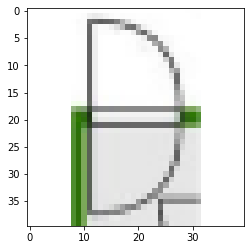

In [50]:
example = next(testiter)
img, label = example
img_rgb = ((img.numpy() + 1)/2 * 255).astype(int)[0]
img_rgb = np.moveaxis(img_rgb, 0, 2)
print(f'Expected: {label[0]}: {classes[label]}')
model2.eval()
predict = model(img).argmax().item()
print(f'Got: {predict}: {classes[predict]}')
plt.imshow(img_rgb)


In [42]:
model.eval()
predict = model(img).argmax().item()
print(f'{predict}: {classes[predict]}')

1: none
